In [1]:
# Neccesary imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from time import time
import random
import glob, os

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from scipy.ndimage.filters import gaussian_filter1d
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from accelerate import Accelerator
cm = plt.get_cmap('RdYlBu')
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import LayerNorm
import math
from sklearn.model_selection import train_test_split
# import seaborn as sns
import matplotlib.colors as mcolors

/tmp/ipykernel_1096167/1954387975.py:17: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
%%time
# Import all the data

data = pd.read_pickle('~/research/galax_spec/grism_specPT.pkl')

CPU times: user 1.29 s, sys: 2.4 s, total: 3.69 s
Wall time: 16.7 s


## Analyze data

In [3]:
data = data[data['SNR']>=2.5]
data

,grism_id,wavelength,flux,z,SNR,continuum_sub_flux
2,aegis-26-G141_00469,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.43,4.094828,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,aegis-26-G141_00703,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.40,20.695364,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,aegis-26-G141_00748,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.91,9.788889,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,aegis-26-G141_00836,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.56,6.308725,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,aegis-26-G141_00880,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.01,3.394737,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
18577,uds-25-G141_42927,"[10208.409432389317, 10209.33721533346, 10210....","[0.11972591812810127, 0.11699151816036778, 0.1...",0.99,3.177632,"[0.11903046440555565, 0.11629269513745405, 0.1..."
18578,uds-25-G141_42956,"[10208.409432389317, 10209.33721533346, 10210....","[0.10640179127421547, 0.10492161739585708, 0.1...",0.92,3.127168,"[0.10595676034947163, 0.10447454305889436, 0.1..."
18580,uds-25-G141_43157,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.06057904419339356, 0.061714234168...",2.87,6.272727,"[0.0, 0.0, 0.0599803052741335, 0.0611124897093..."
18581,uds-25-G141_43202,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.06771137402539505, 0.069817021404...",2.87,15.017544,"[0.0, 0.0, 0.06707207557851437, 0.069174460596..."


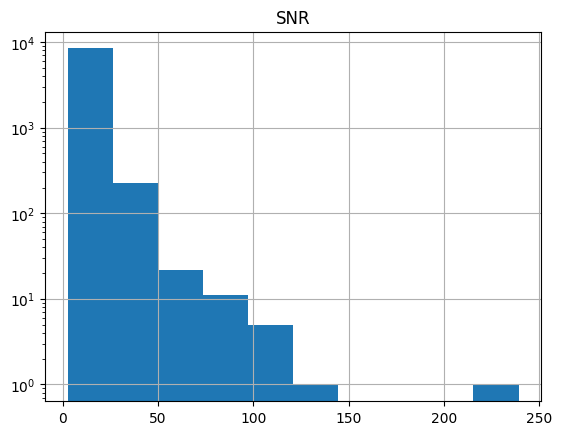

In [4]:
data[data['z']<1.7].hist('SNR')
plt.yscale('log')

array([[<Axes: title={'center': 'z'}>]], dtype=object)

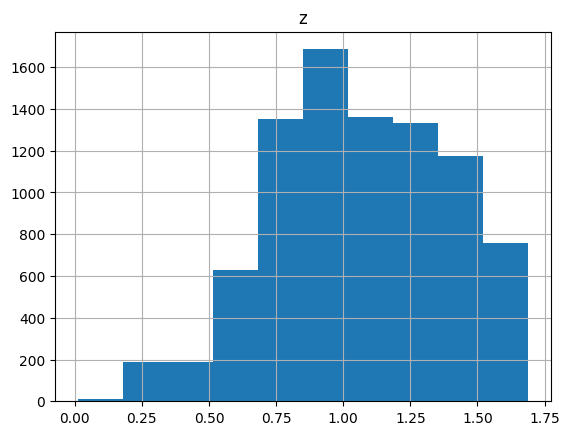

In [5]:
data[data['z']<1.7].hist('z')
# plt.yscale('log')

Compare with ELG distribution
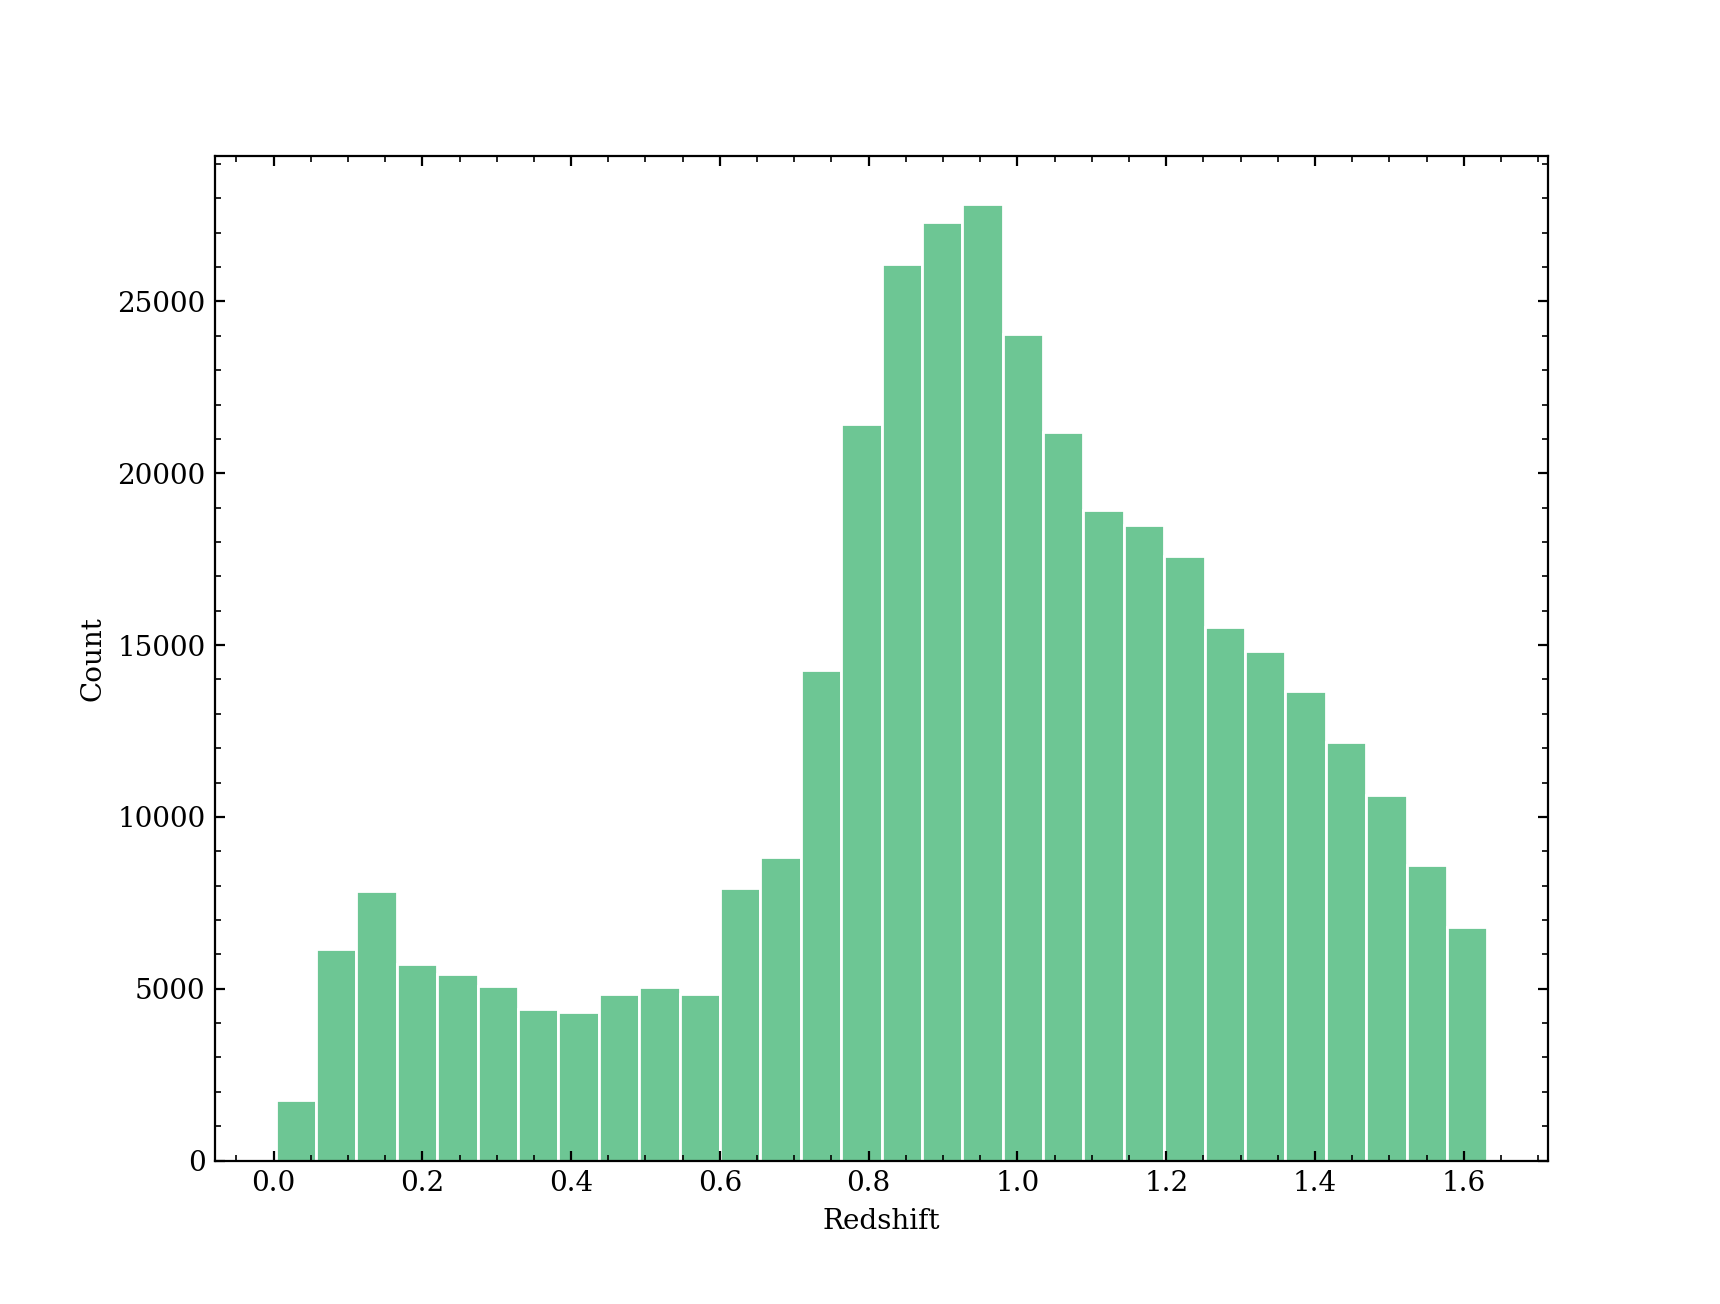

In [6]:
data_subset = data[data['z']<1.7]
data_subset

,grism_id,wavelength,flux,z,SNR,continuum_sub_flux
2,aegis-26-G141_00469,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.43,4.094828,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,aegis-26-G141_00703,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.40,20.695364,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,aegis-26-G141_00836,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.56,6.308725,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,aegis-26-G141_00910,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.05,4.627907,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,aegis-26-G141_00937,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.51,8.418367,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
18575,uds-23-G141_42763,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...",1.34,4.185430,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002..."
18576,uds-05-G141_42909,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.45,2.974790,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18577,uds-25-G141_42927,"[10208.409432389317, 10209.33721533346, 10210....","[0.11972591812810127, 0.11699151816036778, 0.1...",0.99,3.177632,"[0.11903046440555565, 0.11629269513745405, 0.1..."
18578,uds-25-G141_42956,"[10208.409432389317, 10209.33721533346, 10210....","[0.10640179127421547, 0.10492161739585708, 0.1...",0.92,3.127168,"[0.10595676034947163, 0.10447454305889436, 0.1..."


In [7]:
data_subset.iloc[2]['flux']

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
# Split the data into 70% train and 30% temp_test
train_df, temp_test_df = train_test_split(data_subset, test_size=0.3, random_state=42)

# Split the temp_test into 50% test and 50% validation, which is 15% each of the original
test_df, val_df = train_test_split(temp_test_df, test_size=0.5, random_state=42)

print(len(train_df),len(test_df),len(val_df))

6078 1302 1303


In [9]:
class SpecPT(nn.Module):
    def __init__(self, input_size=7781, d_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=2048, dropout=0.1):
        super(SpecPT, self).__init__()

        # Adjusted initial convolutional blocks for feature extraction with new kernel sizes
        self.conv1 = nn.Conv1d(1, 64, kernel_size=41, stride=2, padding=20) # Adjust padding to maintain output size
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=21, stride=2, padding=10) # Adjust padding
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=11, stride=2, padding=5) # Adjust padding
        self.bn3 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Transformer Encoder Layer
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Transformer Decoder Layer
        decoder_layer = TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Dummy input to calculate the output size of the convolutional layers dynamically
        dummy_input = torch.zeros(1, 1, input_size)
        dummy_output = self.forward_conv(dummy_input)
        output_size = dummy_output.numel() // dummy_input.shape[0]  # Calculate total conv output size

        # Projection to d_model size
        self.proj_to_d_model = nn.Linear(output_size, d_model)

        # Final Linear Reconstruction Layers
        self.linear1 = nn.Linear(d_model, output_size)
        self.linear2 = nn.Linear(output_size, input_size)

    def forward_conv(self, x):
        # Pass through Adjusted Convolutional Blocks
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        # Input shape (batch_size, input_size)
        x = x.unsqueeze(1)  # Adding channel dimension (batch_size, 1, input_size)

        # Pass through Convolutional Blocks
        x = self.forward_conv(x)
        
        # Flatten and project to transformer dimension
        x = x.flatten(start_dim=1)
        x = self.proj_to_d_model(x)
        
        # Transformer Encoder & Decoder
        x = x.unsqueeze(0)  # Add sequence dimension for transformer (src_len, batch_size, d_model)
        encoded_features = self.transformer_encoder(x)
        decoded_features = self.transformer_decoder(encoded_features, encoded_features)
        
        # Final Linear Layers
        x = decoded_features.squeeze(0)  # Remove sequence dimension
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        return x




In [10]:
class CustomLoadDataset(Dataset):
    def __init__(self, df):
        x = []
        idx = []
        target_id = []
        for index,row in df.iterrows():
            #Normalizing flux
#             fl = (row['spec'] - row['spec'].min())/(row['spec'].max() - row['spec'].min())
#             fl = gaussian_filter1d(row['spec'], sigma=3)
            fl = row['flux']
#             fl = gaussian_filter1d(fl, sigma=3)
            if np.median(fl) > 0:
                fl = fl/np.median(fl)
#                 if np.sqrt(np.sum(np.square(fl)))==0 or np.isnan(fl).any():
#                     continue
                x.append(fl)
                target_id.append(row['grism_id'])
            else:
                pass

        
            
        self.X = torch.from_numpy(np.stack(x,axis=0))
        self.t_id = target_id
        
#         self.Y = torch.from_numpy(np.stack(y,axis=0))
            
#         self.X = torch.from_numpy(np.stack(x,axis=0))
#         self.Y = torch.from_numpy(np.reshape(df['z'].values,(len(df['z'].values),1)))

#         self.idx = torch.from_numpy(np.reshape(df.index,(len(df.index),1)))
        # self.X = torch.from_numpy(np.random.random((size, 2, 8912)))
        # self.Y = torch.from_numpy(np.random.random((size, 1)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.X[idx].float(), idx, self.t_id[idx]
    
def evaluate(net, loader, criterion, accelerator):
    # Ensure the model is in evaluation mode
    net.eval()

    # Initialize the loss
    total_loss = 0
    total_samples = 0

    # Disable gradient calculations
    with torch.no_grad():
        for X, Y, idx, t_id in loader:
            # Use Accelerator to prepare data
            X, Y = accelerator.prepare(X, Y)

            # Perform the forward pass
            output = net(X)
#             output = torch.squeeze(output)

            # Compute the loss
            loss = criterion(output, Y)

            # Accumulate the loss and sample count
            total_loss += loss.item() #* X.size(0)
            total_samples += X.size(0)

    # Calculate the average loss
    average_loss = total_loss / total_samples

    return average_loss 

class NMADLoss(nn.Module):
    def __init__(self, normalization_factor='mad'):
        super(NMADLoss, self).__init__()
        self.normalization_factor = normalization_factor

    def forward(self, input, target):
        # Calculate the Mean Absolute Deviation (MAD)
        mad = torch.mean(torch.abs(input - target))

        # Define the normalization factor
        if self.normalization_factor == 'mad':
            normalization = torch.median(torch.abs(target - torch.median(target)))
        elif self.normalization_factor == 'std':
            normalization = torch.std(target)
        else:
            raise ValueError("Invalid normalization factor. Use 'mad' or 'std'.")

        # Calculate the NMAD loss
        nmad = mad / normalization

        return nmad

In [28]:
# model = SpecPT(input_size=7781,dropout=0.7)#, d_model=32, nhead=8)
model_Desi_combined = SpecPT(input_size=7781,dropout=0.7)#, d_model=32, nhead=8)
model_HST = SpecPT(input_size=7781,dropout=0.7)#, d_model=32, nhead=8)

# model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# Freeze all layers except the last layer
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the last layer
# for param in model.linear2.parameters():
#     param.requires_grad = True

# # Load the model state
# state_dict = torch.load('/mnt/f/research/SpecPT/pretrained_weights/SpecPT_training_DESI_fastspecfit.pth', map_location='cpu')  # Load to CPU first
file_path1 = os.path.expanduser('~/research/galax_spec/pretrained_weights/SpecPT_DESI_combined_autoencoder_150.pth')
file_path2 = os.path.expanduser('~/research/galax_spec/pretrained_weights/SpecPT_training_HST_150.pth')
state_dict1 = torch.load(file_path1, map_location='cpu')  # Load to CPU first
state_dict2 = torch.load(file_path2, map_location='cpu')  # Load to CPU first

# model.load_state_dict(state_dict)
# sum(p.numel() for p in model.parameters())

model_Desi_combined.load_state_dict(state_dict1)
model_HST.load_state_dict(state_dict2)
sum(p.numel() for p in model_Desi_combined.parameters())

/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_1096167/3293443643.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_gl

1120475621

In [24]:
for parameter in model.parameters():
    print(parameter.requires_grad)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [13]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.flux = np.stack(dataframe['flux'].apply(lambda x: np.hstack(x)).values)
        self.labels = dataframe['z'].values
        # self.labels = scaler.fit_transform(self.labels.reshape(-1, 1)).reshape(len(self.labels))

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        flux = torch.tensor(self.flux[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return flux, label

# Create the dataset
classification_dataset = ClassificationDataset(data)

# Create DataLoader for the classification dataset
# Split the dataset into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Create datasets for the classification task
train_classification_dataset = ClassificationDataset(train_data)
val_classification_dataset = ClassificationDataset(val_data)
test_classification_dataset = ClassificationDataset(test_data)

# Create DataLoaders for the classification datasets
train_classification_dataloader = DataLoader(train_classification_dataset, batch_size=64, shuffle=True, drop_last=True)
val_classification_dataloader = DataLoader(val_classification_dataset, batch_size=64, shuffle=False, drop_last=True)
test_classification_dataloader = DataLoader(test_classification_dataset, batch_size=64, shuffle=False, drop_last=True)

In [18]:
valid_loader = DataLoader(CustomLoadDataset(val_df), batch_size=100, shuffle=True)
test_loader = DataLoader(CustomLoadDataset(test_df), batch_size=256, shuffle=False)

In [19]:
# Define CNN hyper-parameters

epochs = 150
batch_size = 32
lr = 5e-5 #orig = 0.001 or 1e-3, best with 5e-5
# weight_decay=1e-4

In [20]:
train_loader = DataLoader(CustomLoadDataset(train_df), batch_size=batch_size, shuffle=True)

In [29]:
accelerator = Accelerator()
device = accelerator.device
model_Desi_combined = model_Desi_combined.to(device)
model_HST = model_HST.to(device)

criterion = NMADLoss(normalization_factor='std')


# optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
optimizer_Desi_combined = torch.optim.Adam(model_Desi_combined.parameters(), lr=lr)
optimizer_HST = torch.optim.Adam(model_HST.parameters(), lr=lr)




# Initialize Accelerator
model_Desi_combined, train_loader, valid_loader, optimizer_Desi_combined, criterion = accelerator.prepare(model_Desi_combined, train_loader, valid_loader, optimizer_Desi_combined, criterion)
model_HST, train_loader, valid_loader, optimizer_HST, criterion = accelerator.prepare(model_HST, train_loader, valid_loader, optimizer_HST, criterion)



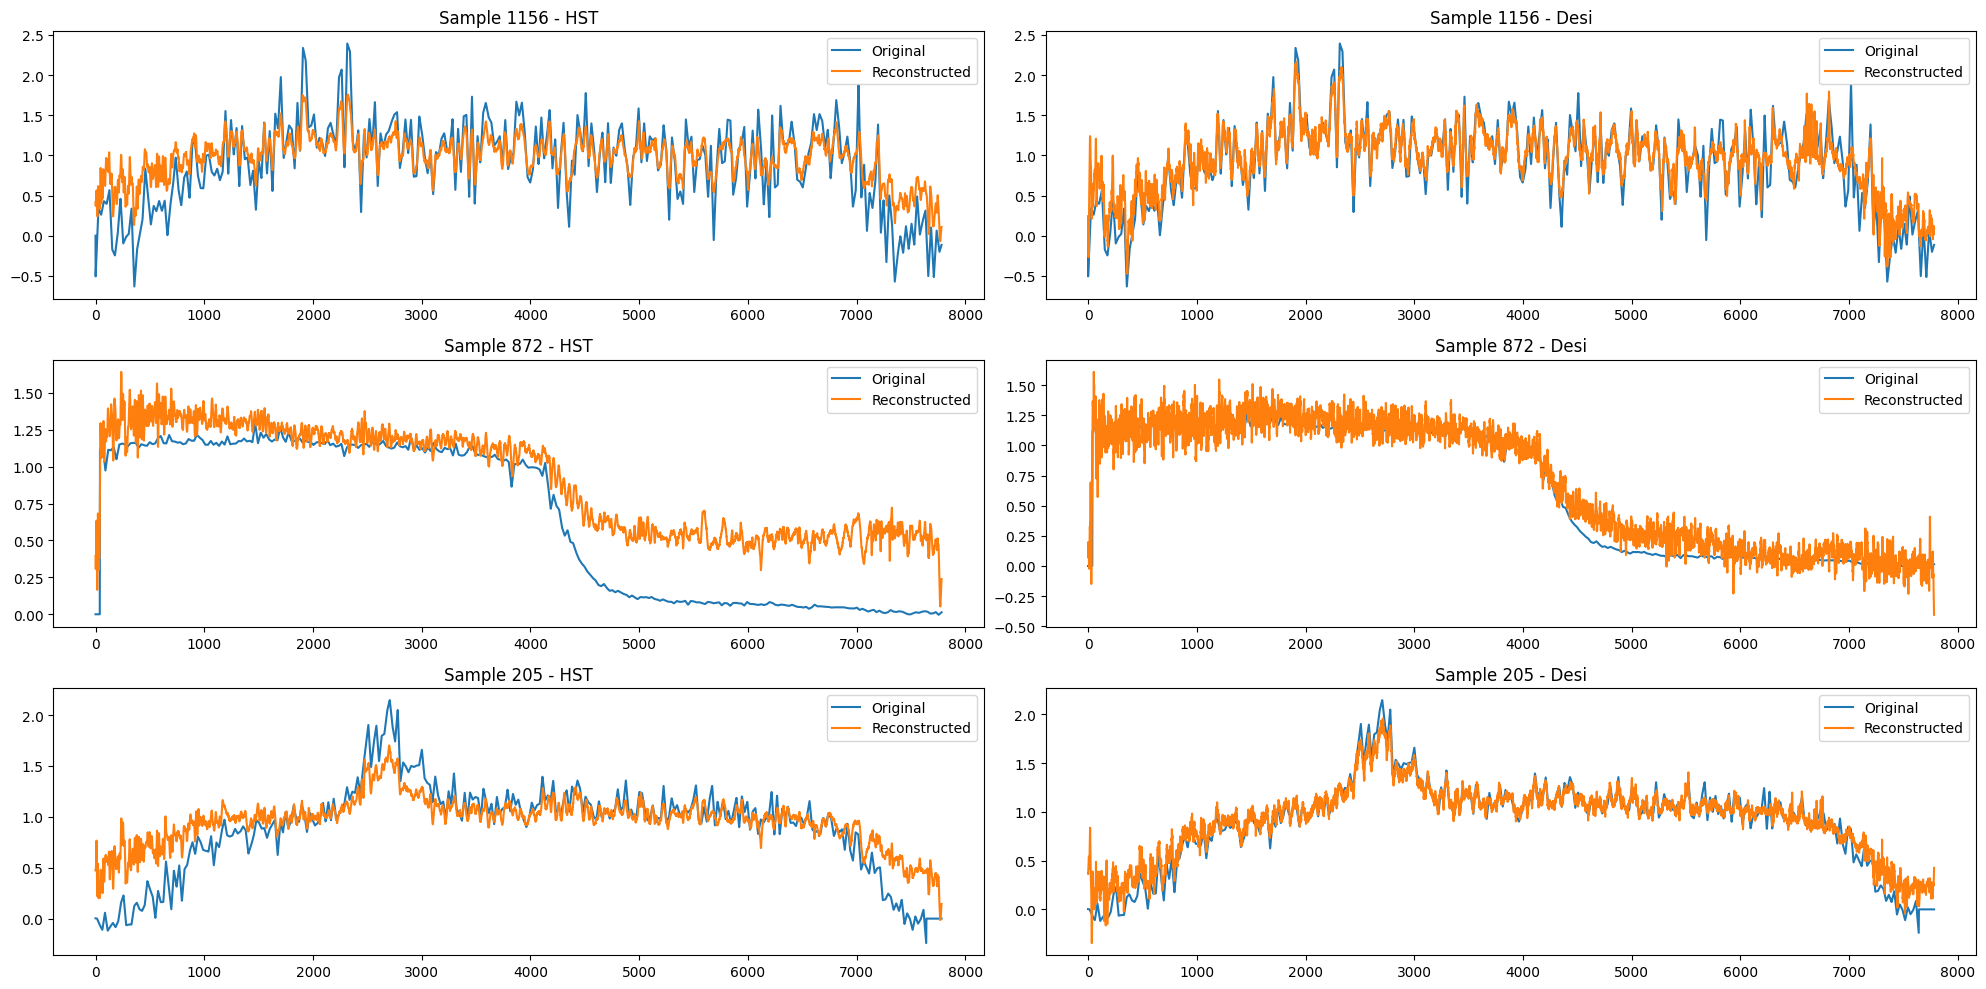

In [44]:
# Select a few samples to compare
num_samples = 3
indices = random.sample(range(len(test_loader.dataset)), num_samples)

# Set the models to evaluation mode
model_HST.eval()
model_Desi_combined.eval()

# Plot the original and reconstructed data
plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    original = test_loader.dataset[idx][0].cpu().numpy()
    reconstructed_HST = model_HST(test_loader.dataset[idx][0].unsqueeze(0).to(device)).detach().cpu().numpy().squeeze()
    reconstructed_Desi = model_Desi_combined(test_loader.dataset[idx][0].unsqueeze(0).to(device)).detach().cpu().numpy().squeeze()

    plt.subplot(num_samples, 2, 2*i+1)
    plt.plot(original, label='Original')
    plt.plot(reconstructed_HST, label='Reconstructed')
    plt.title(f'Sample {idx} - HST')
    plt.legend()

    plt.subplot(num_samples, 2, 2*i+2)
    plt.plot(original, label='Original')
    plt.plot(reconstructed_Desi, label='Reconstructed')
    plt.title(f'Sample {idx} - Desi')
    plt.legend()

plt.tight_layout()
plt.show()

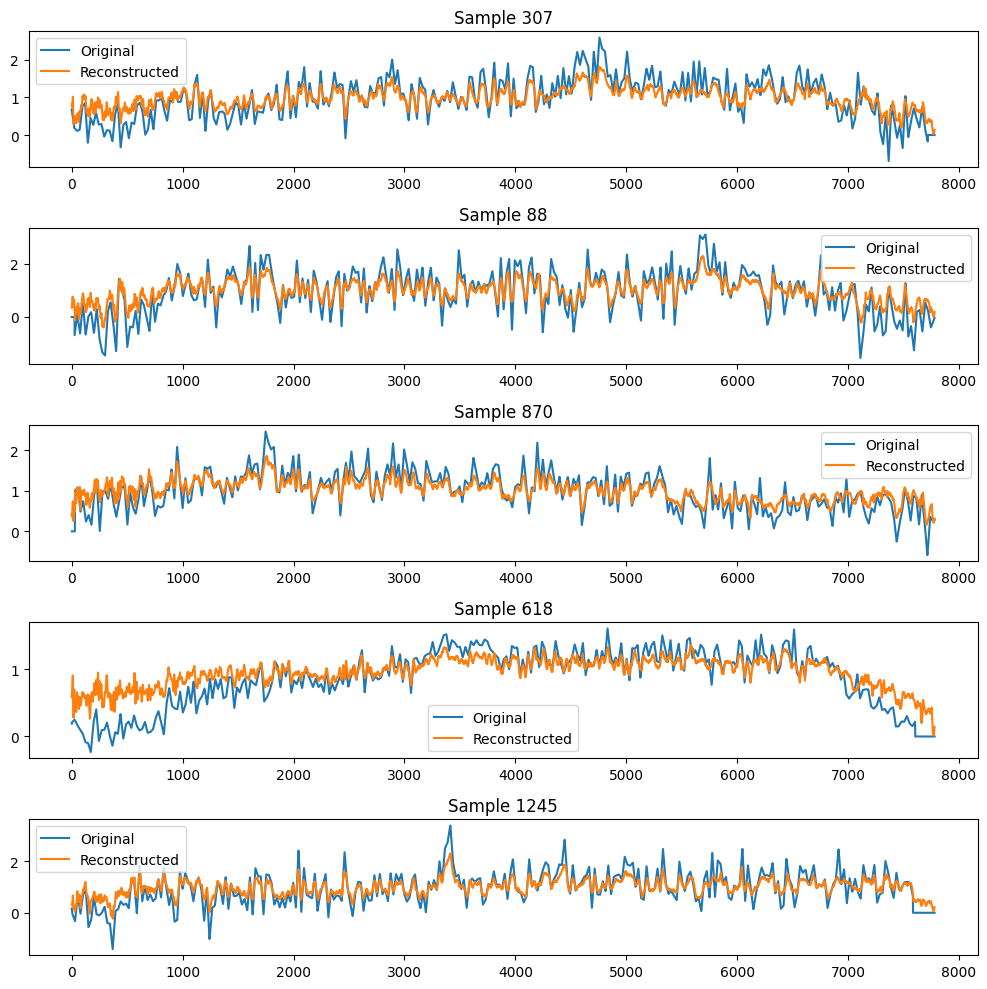

In [27]:
# Select a few samples to compare
num_samples = 5
indices = random.sample(range(len(test_loader.dataset)), num_samples)

# Set the model to evaluation mode
model.eval()

# Plot the original and reconstructed data
plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    original = test_loader.dataset[idx][0].cpu().numpy()
    reconstructed = model(test_loader.dataset[idx][0].unsqueeze(0).to(device)).detach().cpu().numpy().squeeze()

    plt.subplot(num_samples, 1, i+1)
    plt.plot(original, label='Original')
    plt.plot(reconstructed, label='Reconstructed')
    plt.title(f'Sample {idx}')
    plt.legend()

plt.tight_layout()
plt.show()


import wandb

wandb.login()



# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="SpecPT_HST",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "batch_size": 64,
    "architecture": "SpecPT Autoencoder",
    "dataset": "HST",
    "epochs": "0-150",
    "criterion": "NMAD(std)",
    }
)

In [67]:
start_time = time()
best_val_loss, overfit, patience = np.inf, 0, 3000
t_loss = []
v_loss = []
for epoch in range(epochs):
#     model.zero_grad()
    model.train()
    alpha_mean = {}
    train_loss = 0.0
    for step, (X, Y, idx, t_id) in enumerate(train_loader):
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
#         model.zero_grad()
        pred = model(X)
        loss = criterion(pred, Y)
        train_loss += loss.item()
        
        
        
        # Backward pass and optimize
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

    train_loss /= len(train_loader.dataset)
    print('Epoch:', epoch, '\n\tTrain loss:', train_loss)
    t_loss.append(train_loss)
    # np.savetxt('train_loss_HST_'+str(epochs)+'.txt',np.array(t_loss))
    
#     train_time = time()
#     temp = train_time-start_time
#     hours = temp//3600
#     temp = temp - 3600*hours
#     minutes = temp//60
#     seconds = temp - 60*minutes
#     print('Time elapsed since start:')
#     print('%dh%dm%ds' %(hours,minutes,seconds))

    # Early stopping
    model.eval() #Added extra!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    if valid_loader is not None:
        val_loss = evaluate(model, valid_loader, criterion, accelerator)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), '/home/ckb2084/research/galax_spec/saved_models/SpecPT_training_HST_'+str(epochs)+'.pth')
            overfit = 0
        else:
            overfit += 1
            if overfit >= patience:
                model.load_state_dict(torch.load('/home/ckb2084/research/galax_spec/saved_models/SpecPT_training_HST_'+str(epochs)+'.pth',weights_only=True))
                break
        print('\tVal Loss:', val_loss)
        print('\tBest Val Loss:', best_val_loss)
        print('\tBest Epoch:', best_epoch)
        # log metrics to wandb
        # wandb.log({"val_loss": val_loss, "train_loss": train_loss, "best_epoch": best_epoch})
        v_loss.append(val_loss)
        # np.savetxt('val_loss_HST_'+str(epochs)+'.txt',np.array(v_loss))
        val_time = time()
        temp = val_time-start_time
        hours = temp//3600
        temp = temp - 3600*hours
        minutes = temp//60
        seconds = temp - 60*minutes
        print('Time elapsed since start:')
        print('%dh%dm%ds' %(hours,minutes,seconds))
        if np.isnan(train_loss):
            print("Loss is NaN. Stopping training.")
            break 
            
# wandb.finish()

Epoch: 0 
	Train loss: 0.007032115226559147
	Val Loss: 0.003391862675370906
	Best Val Loss: 0.003391862675370906
	Best Epoch: 0
Time elapsed since start:
0h0m18s
Epoch: 1 
	Train loss: 0.006401050672457929
	Val Loss: 0.0022631831378804837
	Best Val Loss: 0.0022631831378804837
	Best Epoch: 1
Time elapsed since start:
0h0m37s
Epoch: 2 
	Train loss: 0.00609741371275365
	Val Loss: 0.002528390388479346
	Best Val Loss: 0.0022631831378804837
	Best Epoch: 1
Time elapsed since start:
0h0m50s
Epoch: 3 
	Train loss: 0.005730483371315813
	Val Loss: 0.004788309965915831
	Best Val Loss: 0.0022631831378804837
	Best Epoch: 1
Time elapsed since start:
0h1m3s
Epoch: 4 
	Train loss: 0.005482201370723283
	Val Loss: 0.0032070154670198916
	Best Val Loss: 0.0022631831378804837
	Best Epoch: 1
Time elapsed since start:
0h1m17s
Epoch: 5 
	Train loss: 0.005366205458461558
	Val Loss: 0.0031027565301642588
	Best Val Loss: 0.0022631831378804837
	Best Epoch: 1
Time elapsed since start:
0h1m30s
Epoch: 6 
	Train loss:

In [42]:
torch.save(model.state_dict(), 'saved_models/SpecPT_training_HST_'+str(epochs+1)+'.pth')

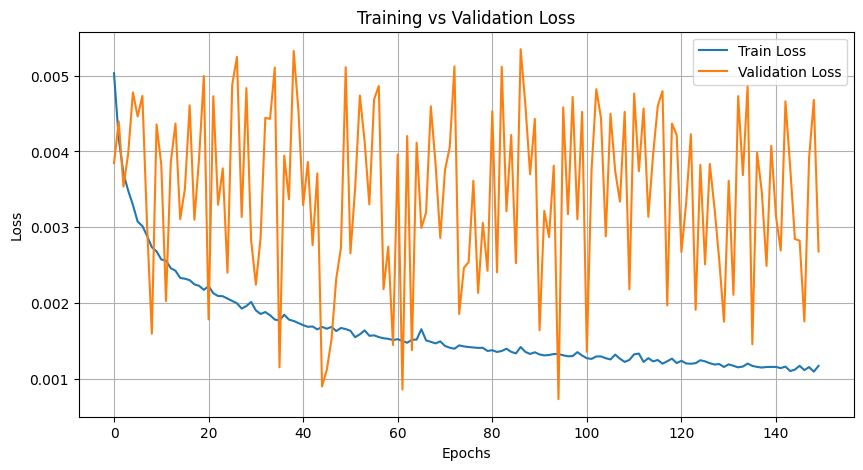

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Train Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

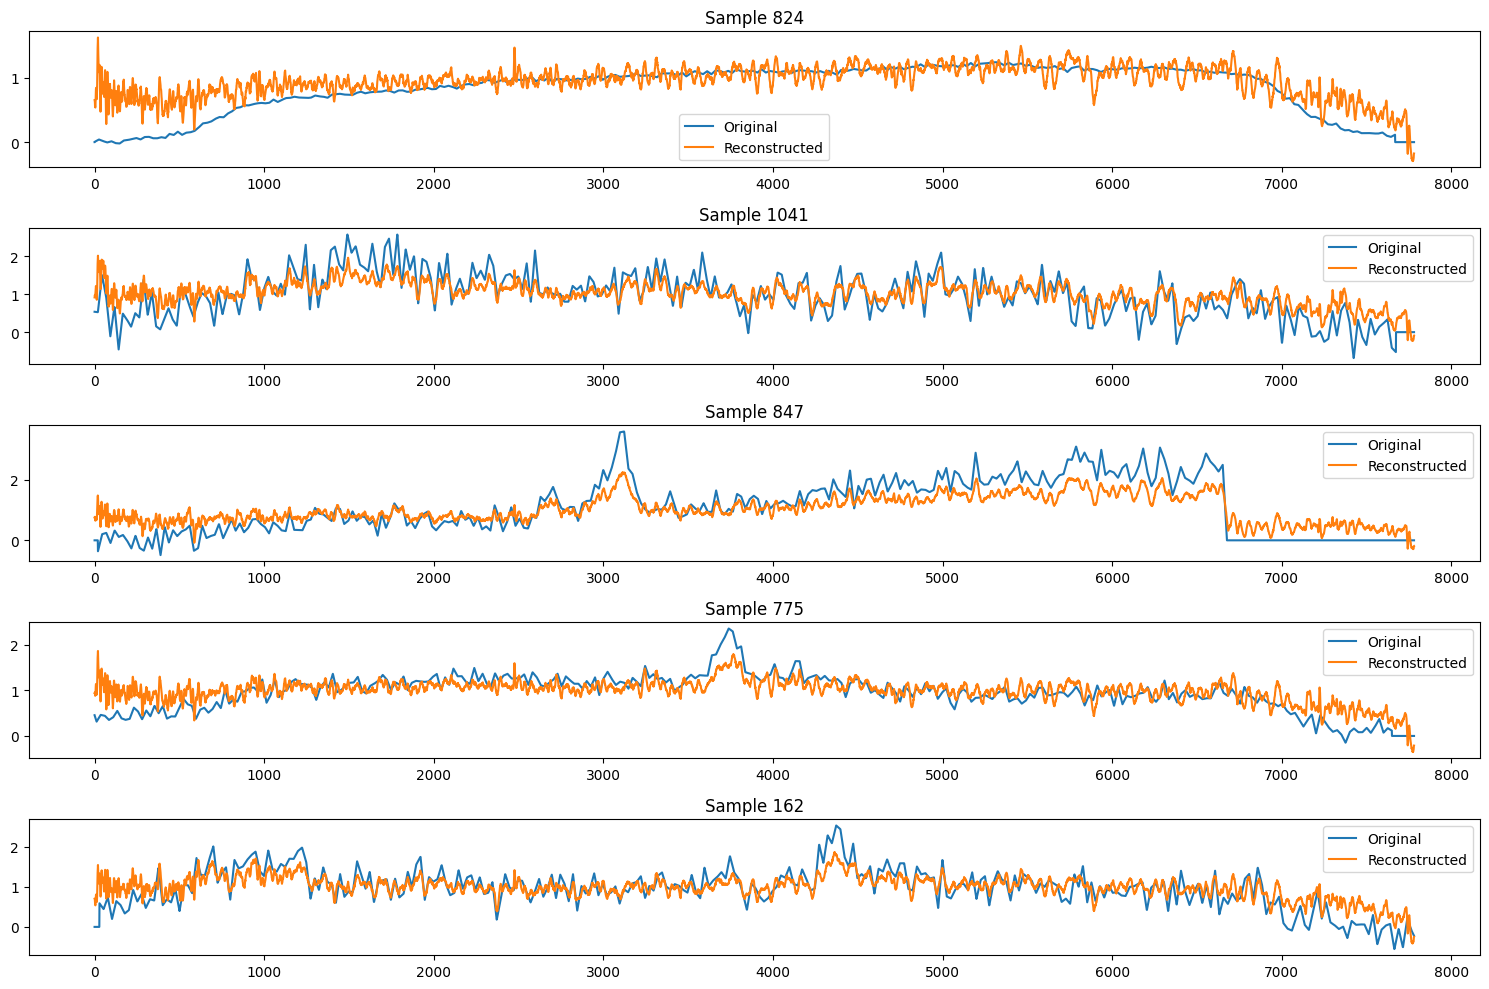

In [60]:
# Select a few samples to compare
num_samples = 5
indices = random.sample(range(len(test_loader.dataset)), num_samples)

# Set the model to evaluation mode
model.eval()

# Plot the original and reconstructed data
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    original = test_loader.dataset[idx][0].cpu().numpy()
    reconstructed = model(test_loader.dataset[idx][0].unsqueeze(0).to(device)).detach().cpu().numpy().squeeze()

    plt.subplot(num_samples, 1, i+1)
    plt.plot(original, label='Original')
    plt.plot(reconstructed, label='Reconstructed')
    plt.title(f'Sample {idx}')
    plt.legend()

plt.tight_layout()
plt.show()
